In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess

In [3]:
from ts_tools import *

In [4]:
#load train
store_sales = pd.read_csv(
    'input_data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index('date').sort_index()

#load test
test = pd.read_csv(
    'input_data/test.csv',
    usecols=['store_nbr', 'family', 'date', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True
)
# test['date'] = test.date.dt.to_period('D')
test = test.set_index('date').sort_index()

In [5]:
full = pd.concat([store_sales, test])

In [6]:
full['day'] = full.index.day_of_week
full['week'] = full.index.week
full['month'] = full.index.month
full['year'] = full.index.year

/tmp/ipykernel_20942/225413157.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  full['week'] = full.index.week


## Look at the data

In [7]:
#Look at the data
fl = full.loc[full.store_nbr == '1']
fl = fl.groupby(['date', 'family'])['sales'].sum().unstack('family')

In [8]:
cols = fl.columns

#### $Total$

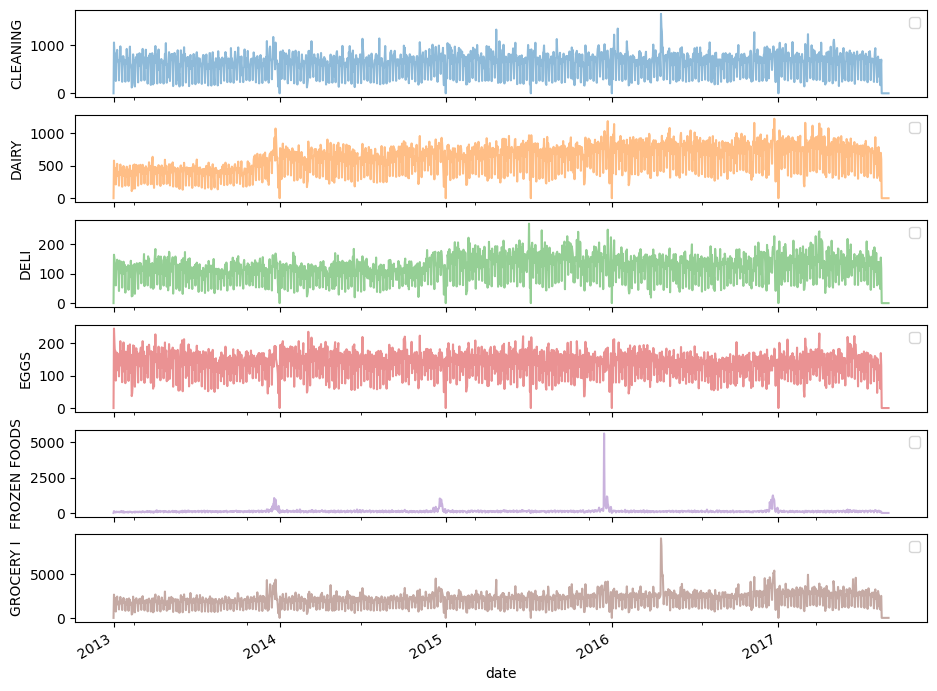

In [9]:
axs = fl.loc[:, cols[7:13]].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
for ax, family in zip(axs, cols[7:13]):
    ax.legend([])
    ax.set_ylabel(family)

###### `There is a little ascending trend and yearly cycles`

#### $Yearly$

In [10]:
fl = fl.loc['2015']

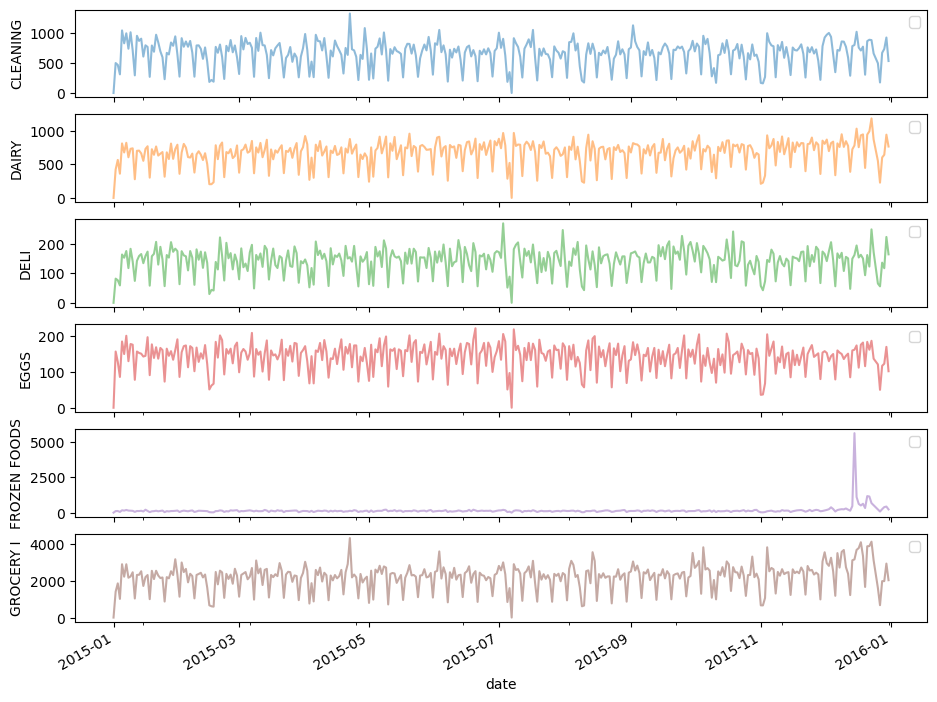

In [11]:
axs = fl.loc[:, cols[7:13]].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
for ax, family in zip(axs, cols[7:13]):
    ax.legend([])
    ax.set_ylabel(family)

###### `There're might be weekly cycles`

## Seasonal check

#### STL decomposition

##### Monthly aggregated data

In [12]:
fl = full.loc[full.store_nbr == '1']
fl = fl.groupby(['date', 'family'])['sales'].sum().unstack('family')

In [13]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

In [14]:
exmp = fl.loc[:, cols[7]]
exmp = exmp.resample('m').mean().ffill()

<Axes: xlabel='date', ylabel='resid'>

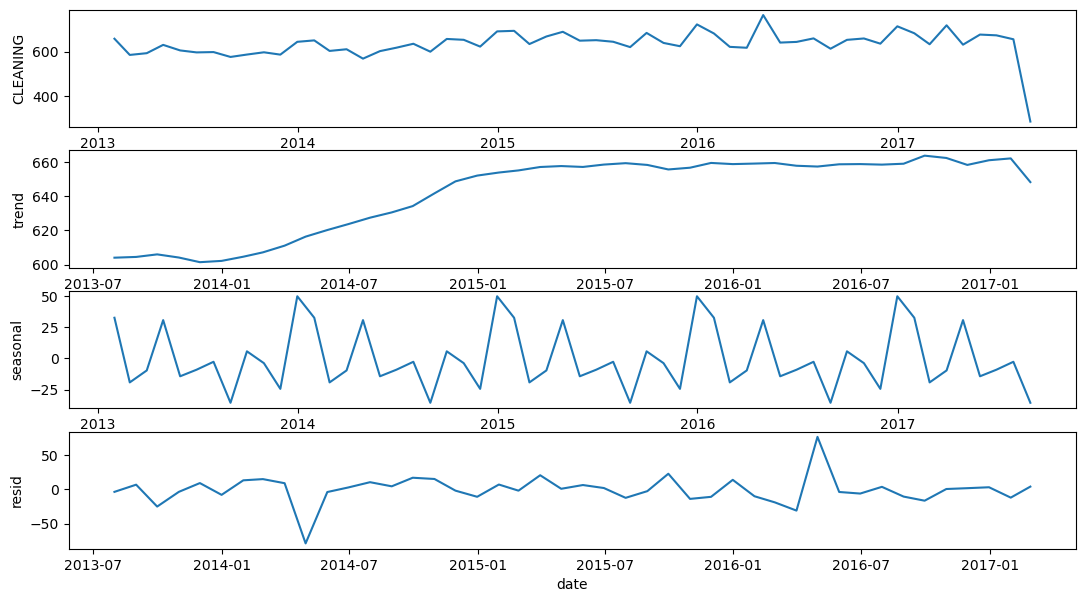

In [15]:
res = seasonal_decompose(exmp, model='additive', period=12)
fig, axes = plt.subplots(4, 1, figsize = (13,7))
sns.lineplot(data = res.observed, ax=axes[0])
sns.lineplot(data = res.trend, ax=axes[1])
sns.lineplot(data = res.seasonal, ax=axes[2])
sns.lineplot(data = res.resid, ax=axes[3])

###### `There are yearly cycles`

In [16]:
fl = full.loc[full.store_nbr == '10']

In [17]:
fl = fl.groupby('date')[['sales']].sum()

In [18]:
fl['day'] = fl.index.day_of_week
fl['week'] = fl.index.week
fl['month'] = fl.index.month
fl['year'] = fl.index.year

/tmp/ipykernel_20942/3736955032.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  fl['week'] = fl.index.week


#### Check for weekly cycles

In [19]:
fl2 = fl.loc['2016']

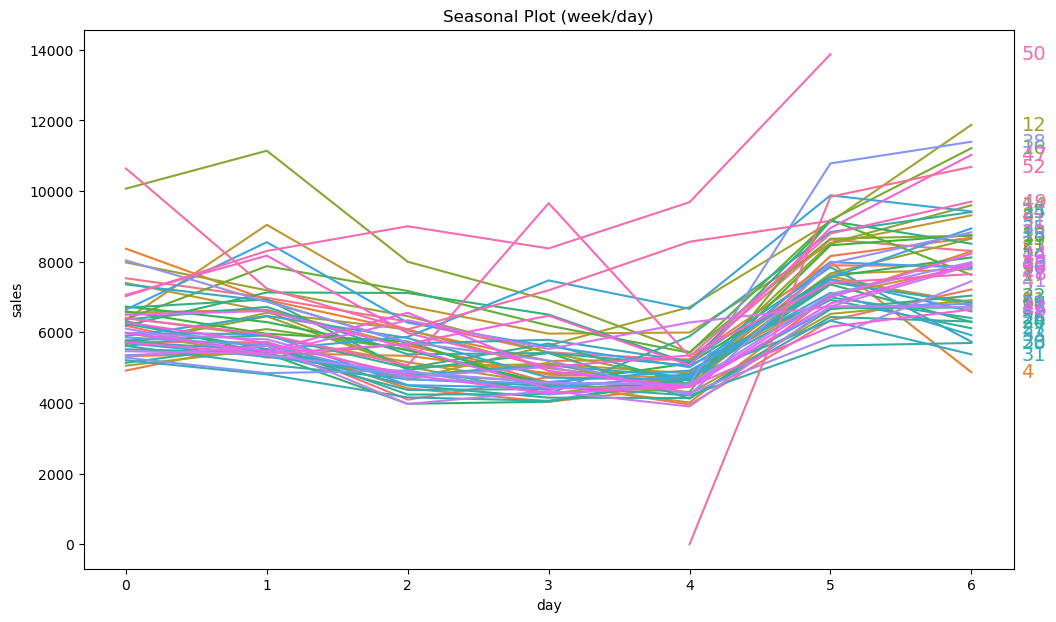

In [20]:
fig, axes = plt.subplots(1, 1, figsize = (12,7))
seasonal_plot(X = fl2.loc[:, ['week', 'day']],
                  y = fl2.loc[:, 'sales'], period = 'week', freq = 'day', ax=axes)
plt.show()

###### `We can easily recognize weekly cycles`

#### Check for yearly cycles

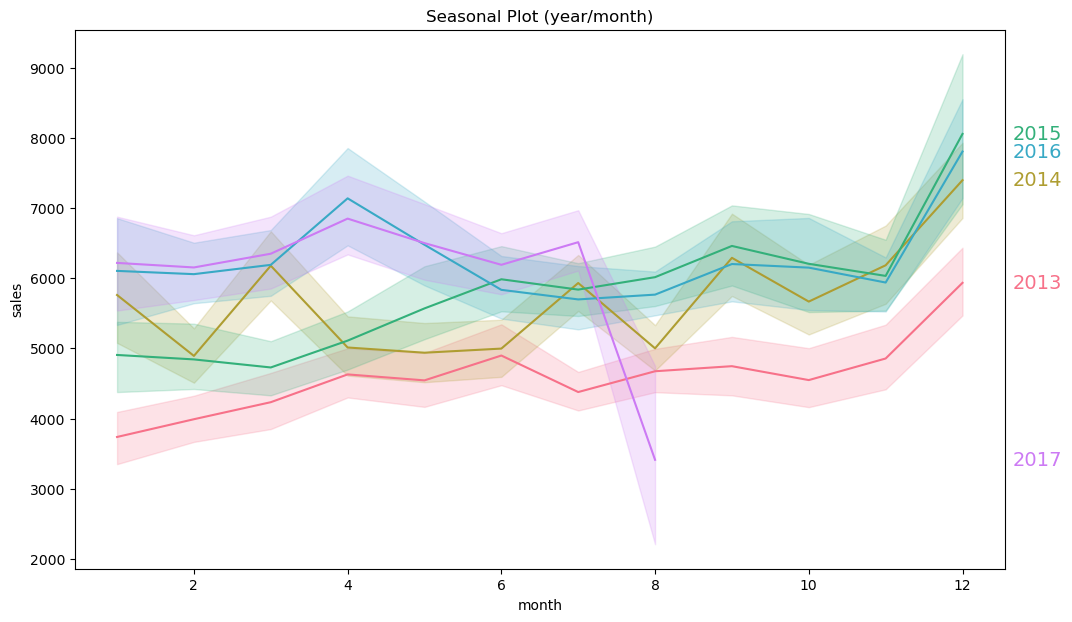

In [21]:
fig, axes = plt.subplots(1, 1, figsize = (12, 7))
seasonal_plot(X = fl.loc[:, ['year', 'month']],
                  y = fl.loc[:, 'sales'], period = 'year', freq = 'month', ax=axes)
plt.show()

###### `There're yearly cycles`

#### Periodigram

/home/jovyan/work/store_sales/ts_tools.py:39: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

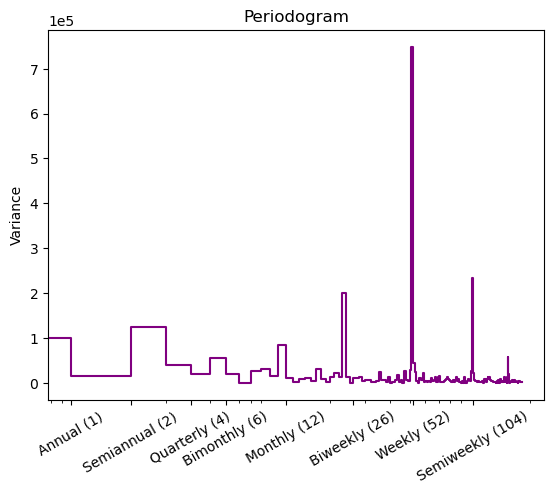

In [22]:
plot_periodogram(fl2.loc[:, 'sales'].dropna())

###### `There're biweekly cycles also (maybe due to salaries on 15th and 30th)`

In [23]:
y = full.groupby(['date', 'store_nbr', 'family'])['sales'].mean().unstack(['store_nbr', 'family'])

In [24]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [25]:
fourier1 = CalendarFourier(freq='y', order=4)
fourier2 = CalendarFourier(freq='M', order=4)

In [26]:
dp = DeterministicProcess(y.index.to_period('D'), order = 1, seasonal=True, additional_terms=[fourier1, fourier2])

In [27]:
X = dp.in_sample()

<Axes: xlabel='date'>

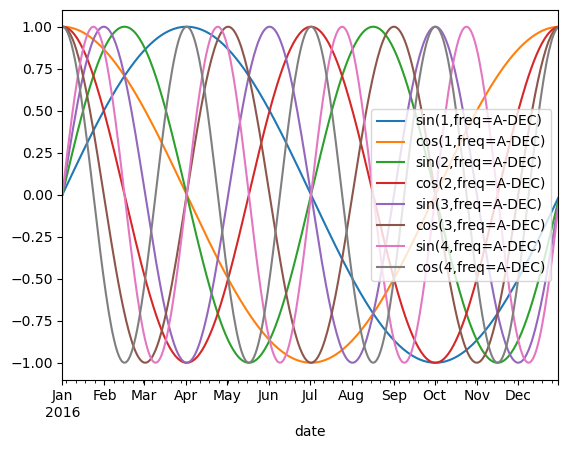

In [28]:
# annual terms
X.loc['2016', X.columns[-16:-8]].plot()

<Axes: xlabel='date'>

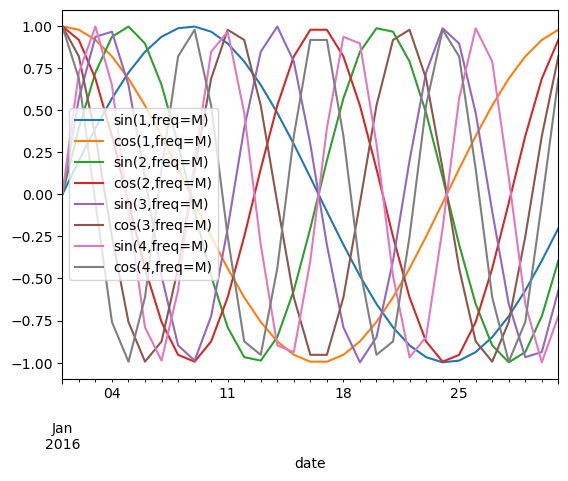

In [29]:
#monthly and biweekly
X.loc['2016-01', X.columns[-8:]].plot()

###### add dates of salaries

In [30]:
X.index = X.index.to_timestamp()

In [31]:
total = full.join(X)

In [32]:
total['salary'] = 0

In [33]:
total.loc[total.index.day == 15, 'salary'] = 1

In [34]:
from pandas.tseries.offsets import MonthEnd

In [35]:
last_days_of_month = (total.index + MonthEnd(0)).unique()

In [36]:
total.loc[total.index.isin(last_days_of_month), 'salary'] = 1

In [37]:
fl2 = fl2.join(X)

#### Deseason the data

###### Check if it's enough features for seasonal comps by 1 step forecasting

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
rg = LinearRegression()

In [40]:
X_ = fl2.drop('sales', 1)
y_ = fl2.loc[:, 'sales']

/tmp/ipykernel_20942/137915106.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_ = fl2.drop('sales', 1)


In [41]:
# fit with default params just for example
rg.fit(X_, y_)
#trend+seasonal comp
y_s = rg.predict(X_)
y_deseason = y_ - y_s

<Axes: xlabel='date'>

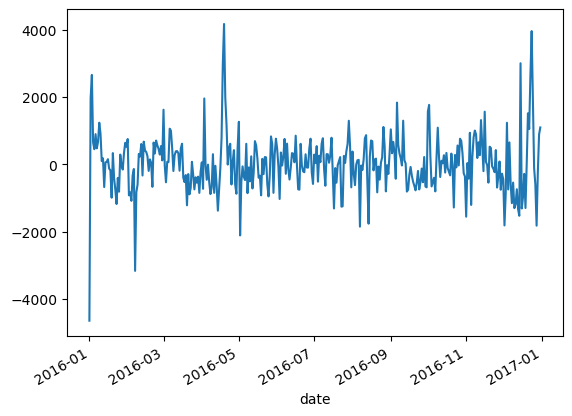

In [42]:
y_deseason.plot()

/home/jovyan/work/store_sales/ts_tools.py:39: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


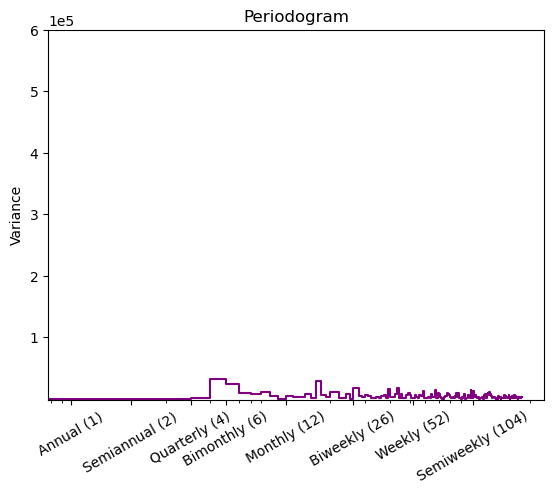

In [43]:
plot_periodogram(y_deseason)
plt.yticks(np.arange(10**5, 7*10**5, 10**5))
plt.show()

##### `reduced for 2 orders`

#### del outliers

###### del outliers

In [44]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(50, contamination=0.02)

In [45]:
total_train = total.dropna()

In [46]:
#Search target outliers in every sku
total_train['outliers'] =\
    total_train.groupby(["store_nbr", "family"],
        group_keys=False)[['sales']].apply(
            lambda x : pd.DataFrame(lof.fit_predict(x),
                index = total_train.index.unique(), columns=['sales']))

/tmp/ipykernel_20942/1788055467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_train['outliers'] =\


In [47]:
#merge outliers
total = total.reset_index().merge(total_train.reset_index()[["date", "store_nbr", "family", "outliers"]], how = 'left').set_index('date')

###### Example for 1 ts

In [48]:
mask_ = (total_train.store_nbr == y.columns[10][0]) &\
                    (total_train.family == y.columns[10][1])

<Axes: xlabel='date', ylabel='sales'>

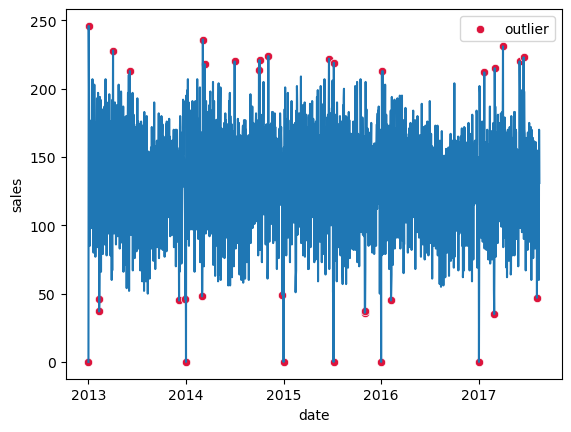

In [49]:
ax = sns.lineplot(data = total_train.loc[mask_], x = 'date', y='sales')
sns.scatterplot(data = total_train.loc[mask_ & (total_train.loc[mask_, 'outliers'] == -1)], x = 'date', y='sales', color="crimson", label="outlier", ax=ax)

In [50]:
total_train = total_train.loc[total_train.outliers != -1]

In [51]:
total_train = total_train.drop("outliers", axis = 1)

### Investigating serial dependences

In [52]:
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


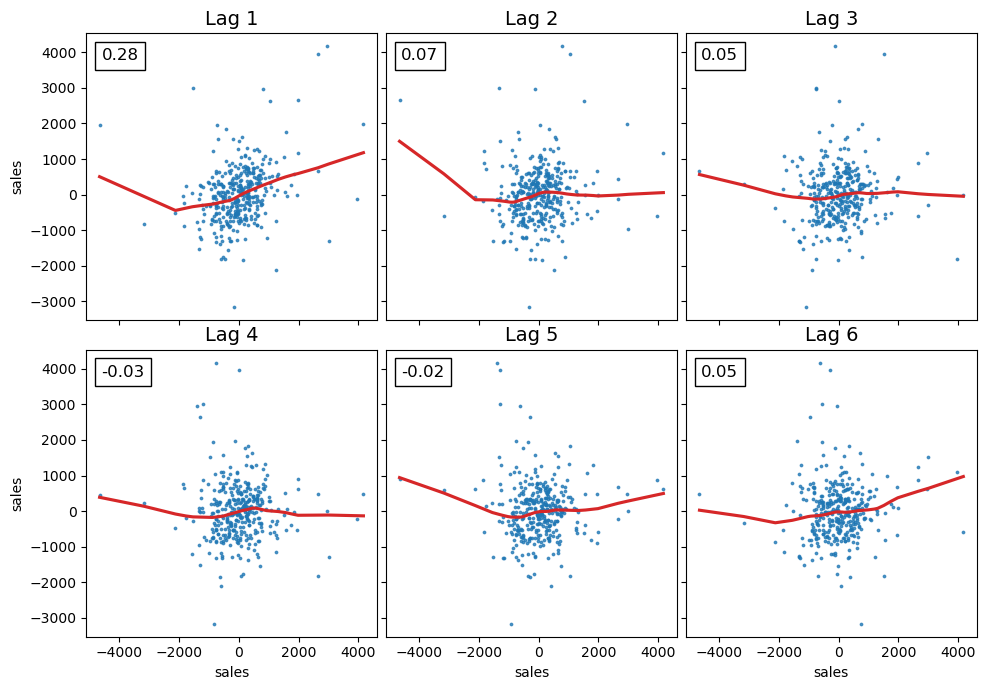

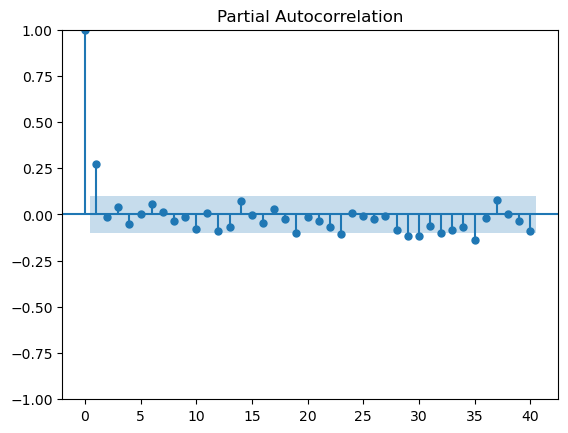

In [53]:
_ = plot_lags(y_deseason, lags=6, nrows=2, figsize = (10,7))
_ = plot_pacf(y_deseason, lags=40)

##### `in the most cases there're 1-2 significant lags`

### Create TS features (Lags, MAs, EMAs, adding multitarget)

In [54]:
y_cols = [x for x in total.columns if x.startswith('sales')]

In [55]:
total.loc[:, y_cols] =\
    total.loc[:, y_cols].apply(np.log1p)

In [56]:
#promos
promos = total.groupby(['store_nbr', 'family'], group_keys=False)['onpromotion'].apply(lambda x : make_multistep_target(x, 16, 'onpromotion'))

In [57]:
#add few lags
lags = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_lags(x, 14))
lags2 = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_lags(x, 31, 30, 30))
lags3 = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_lags(x, 183, 182, 182))

In [58]:
mas = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_mas(x, np.arange(2,15)))
mas2 = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_mas(x, np.arange(30, 91, 30)))
mas3 = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_mas(x, np.arange(182, 365, 182)))

In [59]:
emas = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_emas(x, [round(i,2) for i in np.arange(0.6, 0.95, 0.05)]))

In [60]:
ys = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_multistep_target(x, 16, 'sales'))

In [61]:
target_df = pd.concat([total, promos, lags, lags2, lags3, mas, mas2, mas3, emas, ys], axis = 1)

### Add external features

In [62]:
#info about stores
stores = pd.read_csv('input_data/stores.csv',
        dtype={
        'store_nbr': 'category'
    }
)

In [63]:
target_df = target_df.reset_index().merge(stores, 'left', on = 'store_nbr').set_index('date')

In [64]:
#oil prices
oil = pd.read_csv('input_data/oil.csv',
       parse_dates = True,
       infer_datetime_format=True,
       index_col=0
)

In [65]:
target_df = target_df.join(oil)

In [66]:
target_df['dcoilwtico'] = target_df['dcoilwtico'].fillna(method = 'ffill')

In [67]:
#total transactions
tr = pd.read_csv('input_data/transactions.csv',
        dtype={
        'store_nbr': 'category'
        },
       parse_dates = ['date'],
       infer_datetime_format=True)

In [68]:
target_df = target_df.reset_index().merge(tr, 'left', on = ['date', 'store_nbr']).set_index('date')

In [69]:
#fill 0 to empty transactions
target_df.transactions = target_df.transactions.fillna(0)

In [70]:
#MA for transactions
target_df[['tr_10', 'tr_20', 'tr_30']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['transactions'].apply(lambda x :\
                                                                    make_mas(x, np.arange(10, 31, 10))).values

In [71]:
#MA for transactions
target_df[['tr_1', 'tr_2', 'tr_3']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['transactions'].apply(lambda x :\
                                                                    make_lags(x, 3)).values

In [72]:
#MA for oil price
target_df[['oil_10', 'oil_20', 'oil_30']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['dcoilwtico'].apply(lambda x :\
                                                                    make_mas(x, np.arange(10, 31, 10), 0)).values

In [73]:
#MA for oil price
target_df[['oil_1', 'oil_2', 'oil_3']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['transactions'].apply(lambda x :\
                                                                    make_lags(x, 3)).values

In [74]:
#centered MA for oil price
target_df[['oil_c_5', 'oil_c_10', 'oil_c_15']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['dcoilwtico'].apply(lambda x :\
                                                                    make_mas(x, [5, 10, 15], 0, True, 1)).values

In [75]:
#centered MA for oil price
target_df[['promos_c_5', 'promos_c_10', 'promos_c_15']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['onpromotion'].apply(lambda x :\
                                                                    make_mas(x, [5, 10, 15], 0, True, 1)).values

In [76]:
target_df['total_promo'] = target_df.groupby([target_df.index, 'store_nbr'],
                            group_keys=False)['onpromotion'].transform('sum')

In [77]:
#holidays
hd = pd.read_csv('input_data/holidays_events.csv',
       parse_dates = ['date'],
       infer_datetime_format=True)

In [78]:
#del transferres holidays
hd = hd.loc[hd.transferred == False]

In [79]:
hd = hd.set_index('date')

In [80]:
#Country
hd_n = hd.loc[hd.locale == 'National']

In [81]:
#local
hd_l = hd.loc[hd.locale == 'Local']

In [82]:
#regional
hd_r = hd.loc[hd.locale == 'Regional']

In [83]:
hd_n['national'] = 1

/tmp/ipykernel_20942/3754618716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hd_n['national'] = 1


In [84]:
#Add national holidays
target_df = target_df.join(hd_n['national'])
target_df['national'].fillna(0, inplace=True)
target_df['national'] = target_df['national'].astype('int')

In [85]:
target_df['national'].sum()

249480

In [86]:
hd_l = hd_l.rename({'locale_name':'city'}, axis = 1)

In [87]:
hd_l['local'] = 1

In [88]:
#Add local holidays
target_df = target_df.reset_index().merge(hd_l[['city', 'local']].reset_index(), 'left', ['date', 'city']).set_index('date')
target_df['local'] = target_df['local'].fillna(0)
target_df['local'] = target_df['local'].astype('int')

In [89]:
target_df['local'].sum()

12210

In [90]:
hd_r = hd_r.rename({'locale_name':'state'}, axis = 1)
hd_r['regional'] = 1

In [91]:
#Add regional holidays
target_df = target_df.reset_index().merge(hd_r[['state', 'regional']].reset_index(), 'left', ['date', 'state']).set_index('date')
target_df['regional'] = target_df['regional'].fillna(0)
target_df['regional'] = target_df['regional'].astype('int')

In [92]:
target_df['regional'].sum()

1023

In [93]:
target_df['holiday'] = target_df[['national', 'local', 'regional']].sum(1)

In [94]:
mask_ = (target_df.store_nbr == '1') &\
                    (target_df.family == 'EGGS')
tdf = target_df.loc[mask_]

#### *I want to keep outliers if it's a holiday and delete otherwise*

<Axes: xlabel='date', ylabel='sales_1'>

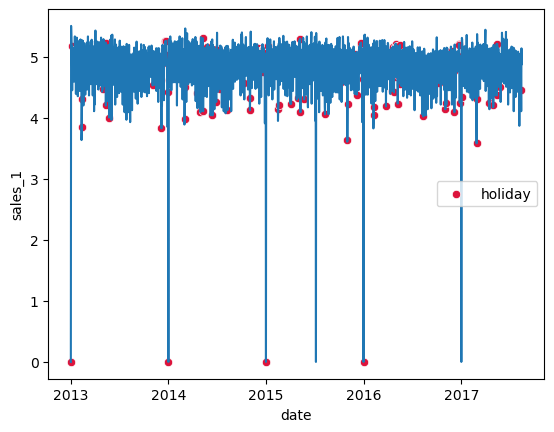

In [95]:
ax = sns.lineplot(tdf.loc[:, 'sales_1'])
sns.scatterplot(data = tdf.loc[tdf['holiday'] == 1], x = 'date', y='sales_1', color="crimson", label="holiday", ax=ax)

<Axes: xlabel='date', ylabel='sales_1'>

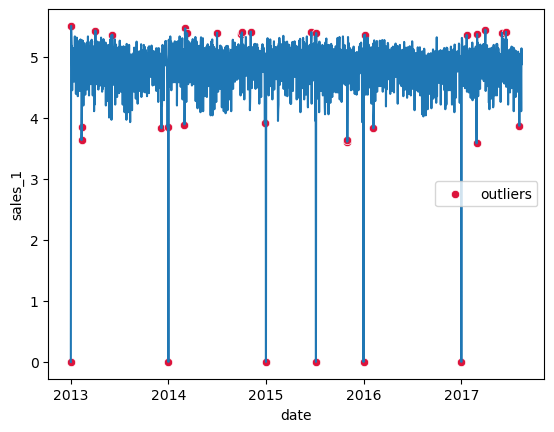

In [96]:
ax = sns.lineplot(tdf.loc[:, 'sales_1'])
sns.scatterplot(data = tdf.loc[tdf['outliers'] == -1], x = 'date', y='sales_1', color="crimson", label="outliers", ax=ax)

In [97]:
#to avoid data_leakage
target_df = target_df.drop(['sales', 'transactions', 'onpromotion'], axis=1)

### Кластеризация

In [98]:
#let's create skus
target_df['sku'] = target_df.store_nbr.astype('str') + '-' + target_df.family.astype('str')

In [99]:
data_cp = target_df.loc[(target_df.year == 2016), ['sku', 'sales_1']].copy()

In [100]:
data_cp = data_cp.groupby(['date', 'sku'])['sales_1'].sum().unstack('sku')

In [101]:
from scipy.cluster import hierarchy
from fastdtw import fastdtw

In [102]:
def dtw(a,b):
    dist, path= fastdtw(a,b, dist=2)
    return dist

In [103]:
%%time
Z = hierarchy.linkage(data_cp.T, method='complete', metric=dtw)

CPU times: user 6min 13s, sys: 12.6 ms, total: 6min 13s
Wall time: 6min 13s


In [104]:
len(target_df.sku.unique())

1782

In [105]:
a = 0
b = 0

In [106]:
[a,b] == [0,0]

True

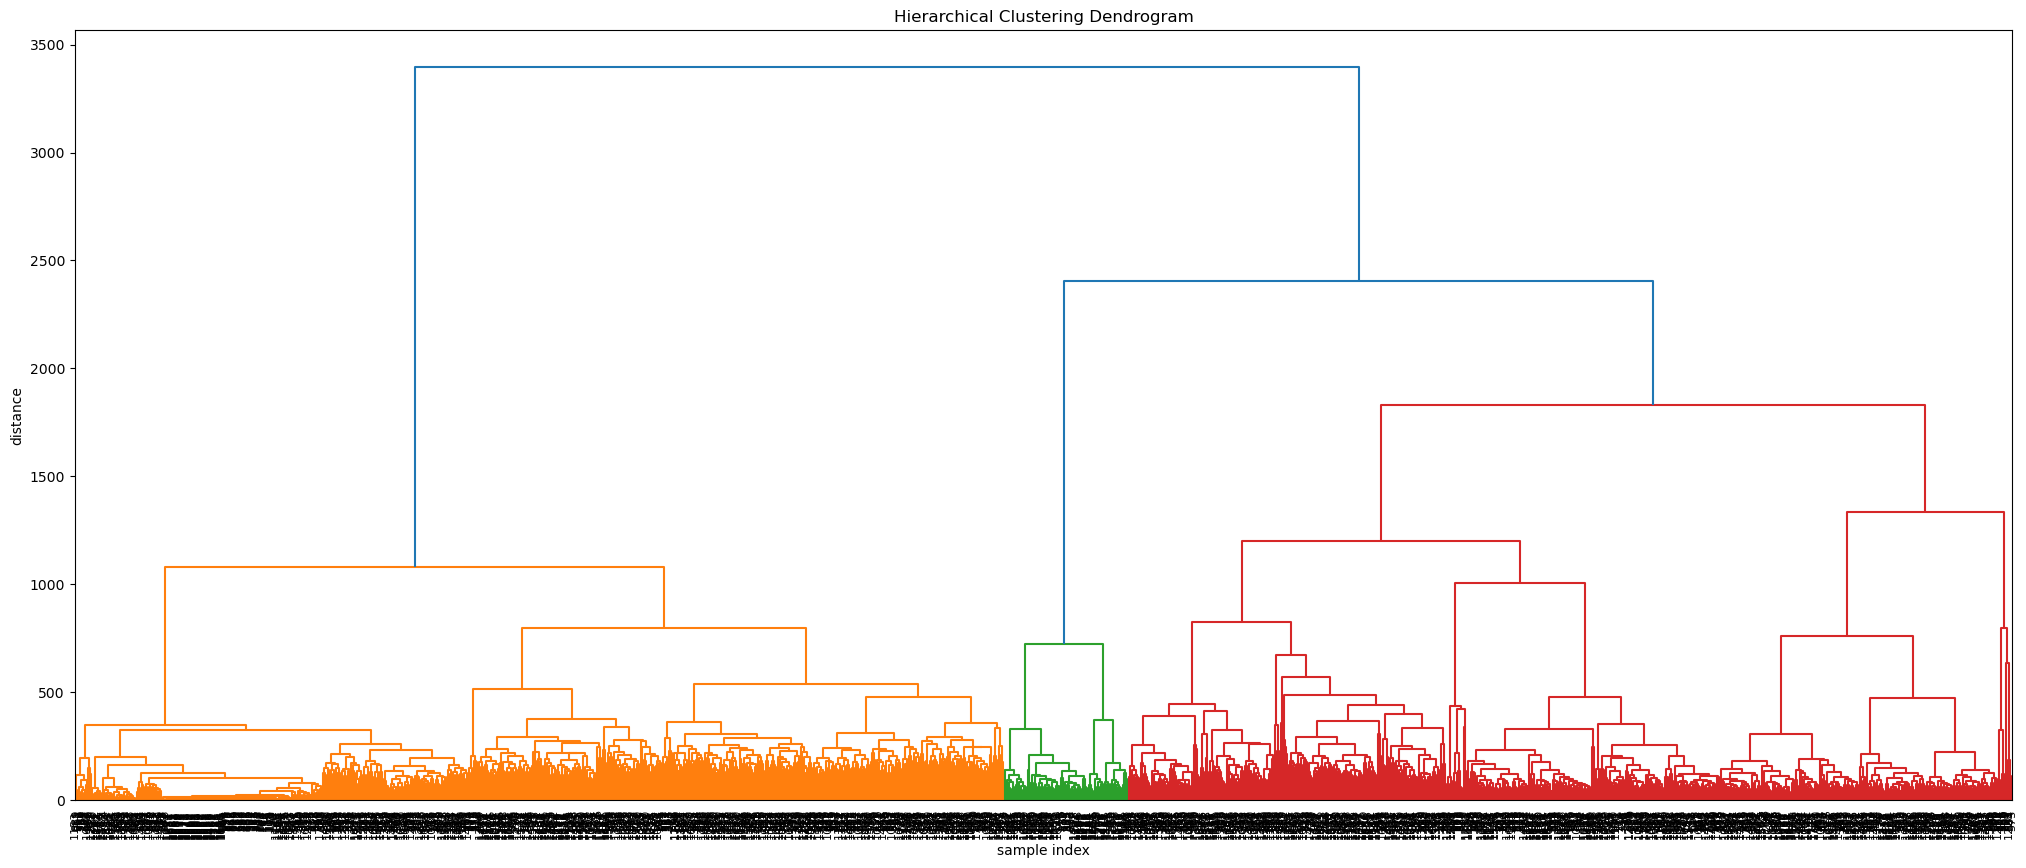

In [107]:
from matplotlib import pyplot as plt
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [108]:
a = hierarchy.fcluster(Z, t = 7, criterion='maxclust')

In [109]:
a = pd.Series(a, index=data_cp.columns)

In [110]:
a.value_counts()

2    493
1    362
4    292
6    254
5    253
3    114
7     14
dtype: int64

In [111]:
a = a.to_dict()

In [112]:
target_df['cluster_sku'] = target_df.sku.apply(lambda x : a[x])

In [113]:
target_df = target_df.loc['2014':]

In [114]:
target_df.to_csv('data.csv')